In [1]:
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace,rand,col
from pyspark.sql.types import StructType,StructField, StringType, IntegerType
import matplotlib.pyplot as plt
import random
import pandas as pd
import inspect

# Execise Sheet 7

## Task 1

### internal structure:
Internally the java hashMap uses an array of a fixed size. Each of the arrays entries contains a linked list in which all
entries with the same index can be stored.

### put operation (adding an element):
First the hash of the key-object is created, in order to do so the key-object's HashCode-Methode is called. The hash is then converted
to an index, by calculating hash % internal_array_size. The linked list which is stored at the calculated index is then scanned
for the new key. If it already contains the key, it does not need to be inserted and a reference is returned. If it is not yet contained
a new entry is created and inserted into the beginning of the list.

### get operation (receiving an element)
Firstly, the hash of the key is calculated. That hash is as before mentioned than turned into an index. The list at said index is than scanned for
any object with the same key. If one is found it is returned, else a null reference is returned.



## Task 2

First we create a spark session:

In [2]:
spark = SparkSession.builder.appName("HelloWorld").getOrCreate()
sc = spark.sparkContext

22/12/09 15:01:49 WARN Utils: Your hostname, jakob-ThinkPad-E15-Gen-4 resolves to a loopback address: 127.0.1.1; using 192.168.111.224 instead (on interface wlp3s0)
22/12/09 15:01:49 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/09 15:01:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Next we define our hashing methode

In [3]:
def define_hashes(number_of_hashes, size_of_rows):
    #We do not know how this will help - as now the integer modulo operation is completely useless..
    prime_used = 2147483647
    hash_functions = []
    for i in range(0,number_of_hashes):
        func = lambda x,a,b: (((a * x + b)% prime_used) % size_of_rows)
        hash_functions.append(func)

    return hash_functions

In [4]:
def compute_minhash(K, N, input):
    hash_functions = define_hashes(K,N)
    find_hash_index_function = lambda x : (np.where(x == np.amin(x))[0]).take(0)
    result=None
    initialized = False
    for function in hash_functions:
        copied_input = input

        # this is due to some weird behaviour were all functions would produce the same values
        # it contradicts the task at hand to calculate the methods beforehand, but we could not get that to work
        a = random.randint(1,2147483647)
        b = random.randint(1,2147483647)
        func = lambda x: (((a * x + b)% 2147483647) % 30)

        input_hashed = copied_input.map(func)
        min_hashed = input_hashed.map(find_hash_index_function)
        if initialized:
            result = np.vstack((result,np.array(min_hashed.collect(),dtype='int32')))
        else:
            result = np.array(min_hashed.collect(),dtype='int32')
            initialized = True

    print('Created Signature of size: '+str(result.shape))
    result_rdd = sc.parallelize(result.T)
    print("The output has the datatype: " +str(result_rdd.first().dtype))
    return result_rdd


Now we can do some verification:

In [5]:
def create_input_data():
    size_vector = 20000
    amount_to_replace = int(size_vector * 0.02)

    #create start vector S0
    S0 = np.sort(np.random.randint(1,100000,size=size_vector,dtype='int32'))
    S0 = np.reshape(S0,(1,-1))
    S = S0
    last_set = S0

    for i in range(1,100):
        Si=last_set
        random_values = np.random.randint(1,100000,size=amount_to_replace,dtype='int32')
        random_index = np.random.randint(0,size_vector,size=amount_to_replace)

        for j in range(0, amount_to_replace):
            rand_val = random_values[j]
            rand_ind = random_index[j]
            Si[0][rand_ind]=rand_val

        Si = np.sort(Si)
        last_set = Si
        S = np.vstack((S,Si))

    #lastly we convert the numpy matrix to a spark rdd
    print("Created input of shape" + str(S.shape))
    rdd_S = sc.parallelize(S)
    print("The input has the datatype: " +str(rdd_S.first().dtype))
    return rdd_S

In [6]:
input_data = create_input_data()

result_rdd = compute_minhash(30, 5, input_data)

## lastly we want to print the result for K=30
## as well as giving the pairwise similarities
print('The result hash-key matrix for K=30 looks as follows')
result = result_rdd.collect()
print(result)

print('Comparing the similarities')
S0 = result[0]

for i in range(1,30):
    print('Comparing S0 and S'+str(i))
    Si = result[i]
    count_identical = np.where(S0 == Si)[0].shape[0]
    print('Identical results: '+str(count_identical))
    print('Percentage: '+str(count_identical/30))
    print('------------------------------------')



Created input of shape(100, 20000)


The input has the datatype: int32
Created Signature of size: (30, 100)
The output has the datatype: int32
The result hash-key matrix for K=30 looks as follows
[array([  5,  14,  91,  24,   9,  14,   2,  32,  11,   5,   1, 142,  37,
         0,  51,   2,  27,  21,  15,  82,  33,  27,   4,   0,   9,   2,
         8,   0,   2,   3], dtype=int32), array([  5,  14,  89,  24,   9,  14,   2,  31,  11,   5,   1, 139,  35,
         0,  49,   2,  27,  21,  15,  80,  32,  27,   4,   0,   9,   2,
         8,   0,   2,   3], dtype=int32), array([  5,  14,  91,  24,   9,  14,   2,  31,  11,   5,   1, 139,  35,
         0,  45,   2,  27,  21,  15,  82,  32,  27,   4,   0,   9,   2,
         8,   0,   2,   3], dtype=int32), array([  5,  14,  91,  24,   9,  14,   2,  31,  11,   5,   1, 137,  35,
         0,  45,   2,  27,  21,  15,  82,  32,  27,   4,   0,   9,   2,
         8,   0,   2,   3], dtype=int32), array([  5,  14,  92,  24,   9,  14,   2,  32,  11,   5,   1, 138,  36,
         0,  46,   2,  2

## Task 3

PLease note we manually determined the 50% thresholds but added them to the drawings for a more clear and visual understanding

-------------------------------------------
------------ r= 2 -------------------------
-------------------------------------------
--- b= 10


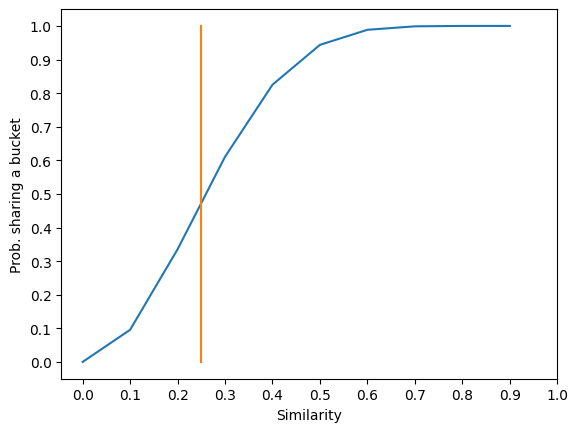

--- b= 20


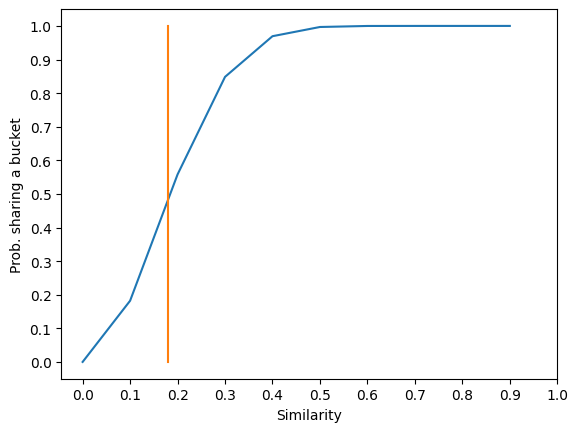

--- b= 50


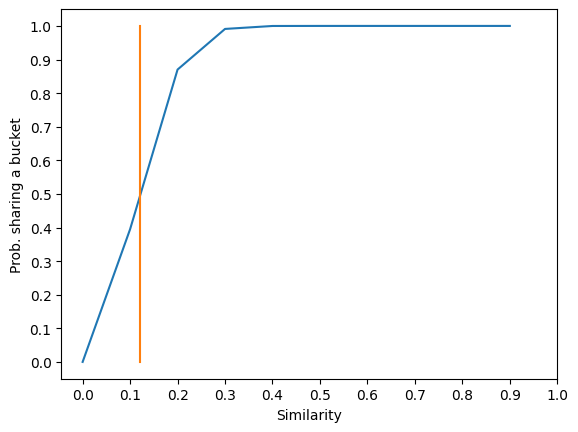

--- b= 1000


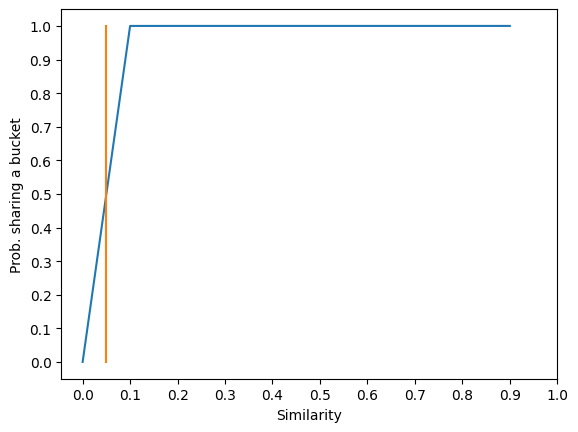

-------------------------------------------
------------ r= 3 -------------------------
-------------------------------------------
--- b= 10


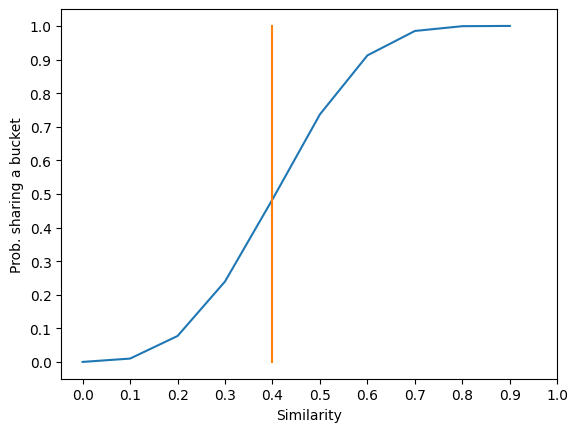

--- b= 20


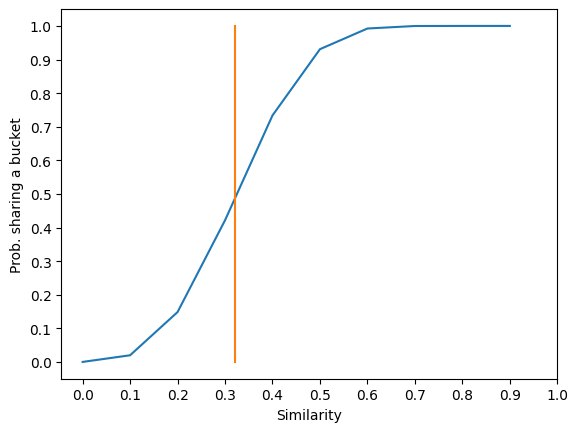

--- b= 50


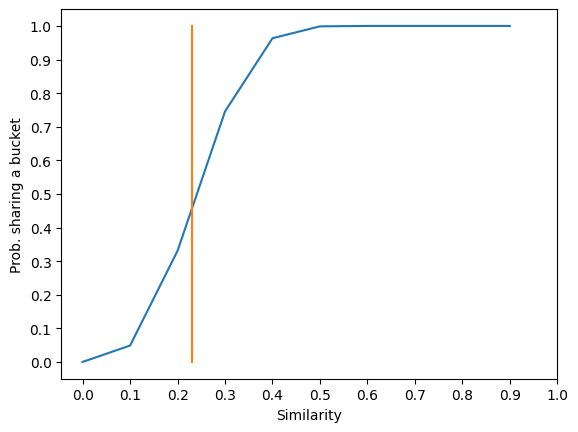

--- b= 1000


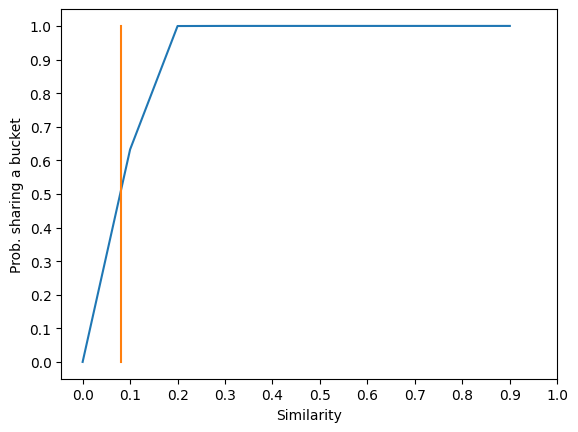

-------------------------------------------
------------ r= 5 -------------------------
-------------------------------------------
--- b= 10


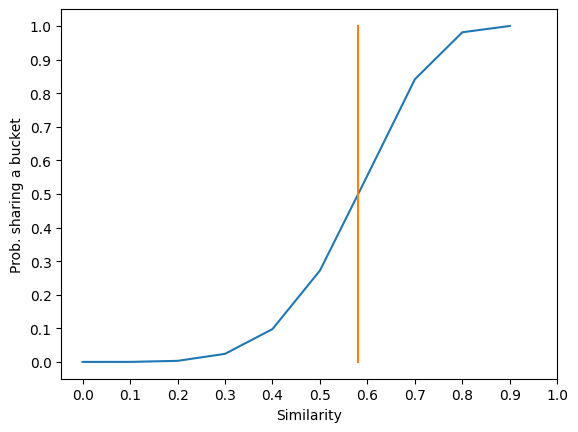

--- b= 20


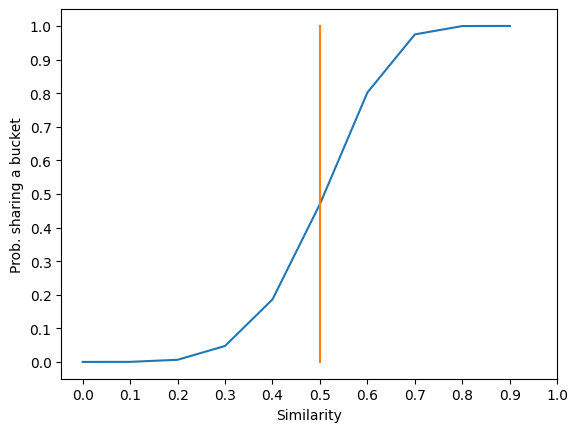

--- b= 50


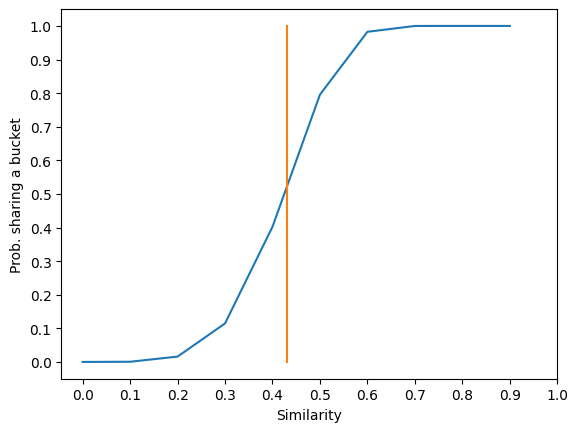

--- b= 1000


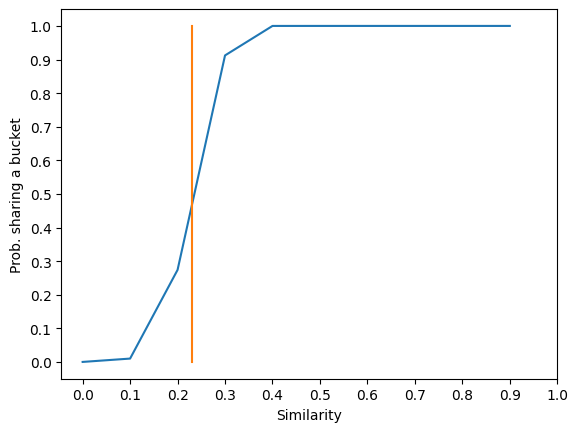

-------------------------------------------
------------ r= 7 -------------------------
-------------------------------------------
--- b= 10


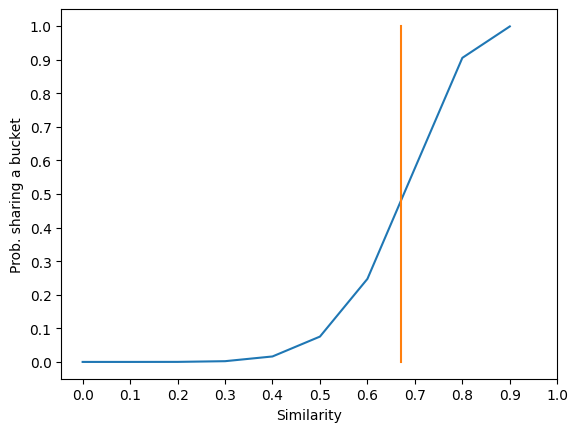

--- b= 20


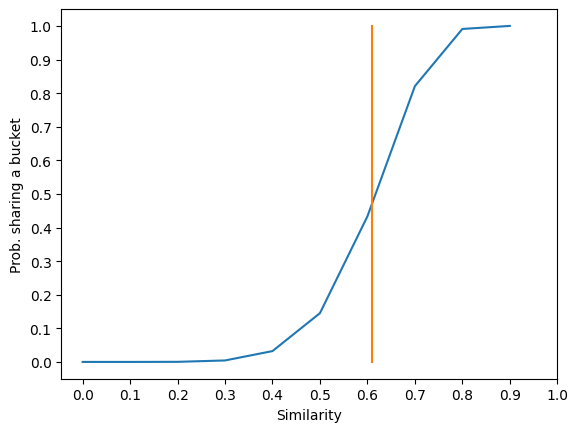

--- b= 50


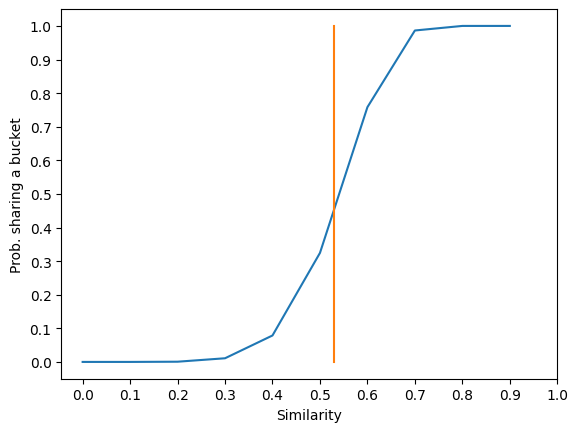

--- b= 1000


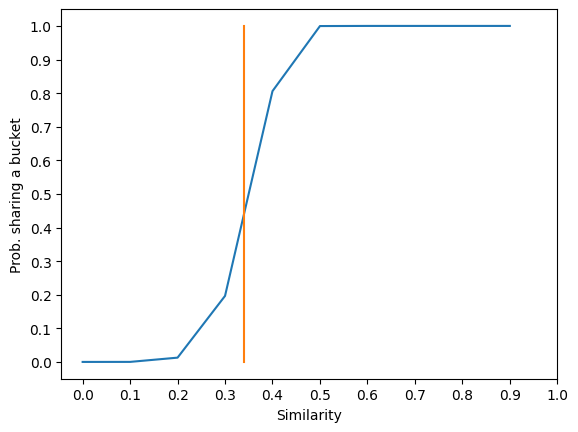

In [7]:
# firstly we create our x-coordinates. We want to inspect a change every 10% than we need to sample 10 entries
x_coordinates = np.arange(0,1,0.1)
numer_of_entries = x_coordinates.shape[0]

# see note
manually_determined = [0.25, 0.18, 0.12, 0.05,
                       0.4, 0.32, 0.23, 0.08,
                       0.58, 0.5, 0.43, 0.23,
                       0.67, 0.61, 0.53, 0.34]

i = 0

for r in [2,3,5,7]:
    print('-------------------------------------------')
    print('------------ r= '+str(r)+' -------------------------')
    print('-------------------------------------------')
    for b in [10,20,50,1000]:
        print('--- b= '+str(b))

        ones = np.ones(numer_of_entries)
        result = ones - np.power((ones - np.power(x_coordinates,r)),b)
        plt.plot(x_coordinates,result)

        x_50_margin=[manually_determined[i],manually_determined[i]]
        y_50_margin=[0,1]
        plt.plot(x_50_margin,y_50_margin)

        plt.xlabel('Similarity')
        plt.ylabel('Prob. sharing a bucket')
        plt.xticks(np.arange(0, 1.1, 0.1))
        plt.yticks(np.arange(0, 1.1, 0.1))
        plt.show()

        i += 1

### Task 4

#### a)

Whenever the dead end removal is called all laves of the graph are removed. Leaves being the nodes
at the furthest distance from the root, which hence have no outgoing edges themselves.

Therefore, each recursive call is going to remove one layer of leaves. If we repeat this n-1 times we are only
left with the root node, which can not get removed as it has outgoing and incoming edges.

As the resulting page rank matrix must be completely stochastic the pagerank of the root must be 1.

### b)

This computes from 2 different sources the incoming rank from the root which is divided up. Hence, at the i-th
with a rank of the root of r this part is approximately $\frac{r}{2^{i}}$. (Only approx. as the root has a self self-reverence as well)

The second factor is the teleport rank which is $\frac{1}{n}$

Putting it together with a teleport probability of beta we receive for dead ends of the i-th layer.

$\[(1-\beta) * \frac{r}{2^{i}}\] +\[ \beta * \frac{1}{n}\]$
